In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import nnls
from tqdm import tqdm

# all toxic labels
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


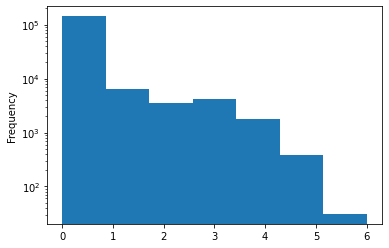

In [ ]:
# histogram of number of labels per examples
df_labels = df[toxic_labels]
df_labels.sum(axis = 1).plot.hist(log = True, bins = 7)

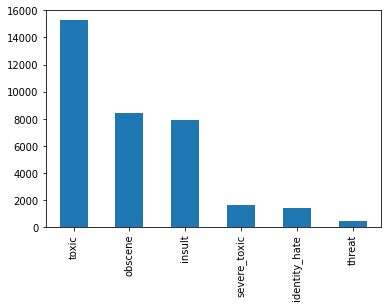

In [ ]:
# get count of each label
label_counts = df_labels.sum().to_dict()
df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [ ]:
def categorical_entropy(df, labels = toxic_labels):
    # entropy for labels across the dataset
    # p(l) = count(l) / sum(count(l) for l in labels))
    # H = sum(p(l) * -log2 p(l) for l in labels)
    cat_sums = df[labels].sum()
    cat_probs = np.array([cs / cat_sums.sum() for cs in cat_sums])
    return np.sum(cat_probs * -np.log2(cat_probs))


In [ ]:
# entropy for original dataset
categorical_entropy(df)

1.9735258511168368

In [ ]:
# correlation plot for labels
corr = df_labels.corr()
corr.style.background_gradient(cmap='coolwarm')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [ ]:
# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(df, toxic_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = toxic_labels, index = toxic_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,1.000000,0.938099,0.939331,0.932335,0.926690
severe_toxic,0.104289,1.000000,0.179548,0.234310,0.174051,0.222776
obscene,0.518242,0.951097,1.000000,0.629707,0.781389,0.734520
threat,0.029358,0.070219,0.035626,1.000000,0.038974,0.069751
insult,0.480188,0.859561,0.728489,0.642259,1.000000,0.825623
identity_hate,0.085131,0.196238,0.122145,0.205021,0.147264,1.000000


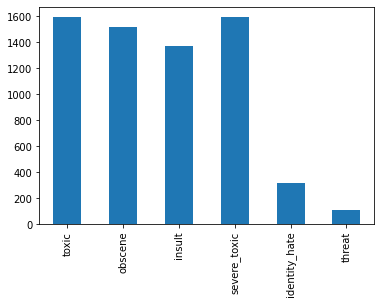

In [ ]:
# counts per label for examples that have severe_toxic label
df[df['severe_toxic'] == 1][sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [ ]:
# naive sampling method
# pick N examples for each label and concat
def naive_sample(df, labels, target_count):
    df_subs = []
    for label in labels:
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(target_count, 
                                     replace = len(sub_df) < target_count))
    sampled_df = pd.concat(df_subs)
    return sampled_df

TARGET_COUNT = 100

sampled_df = naive_sample(df, toxic_labels, TARGET_COUNT)
sampled_df_labels = sampled_df[toxic_labels]
print(len(sampled_df))
sampled_df_labels.sum()

600


toxic            574
severe_toxic     198
obscene          467
threat           124
insult           450
identity_hate    180
dtype: int64

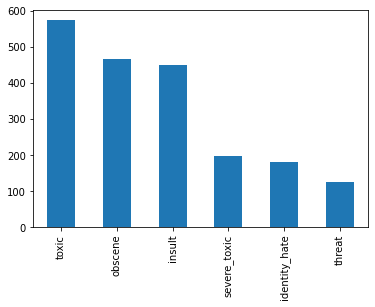

In [ ]:
# counts for naive sampling method
label_counts = sampled_df_labels[toxic_labels].sum().to_dict()
sampled_df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [ ]:
# entropy for sampled dataset. A little higher than the original dataset
categorical_entropy(sampled_df)

2.386042706325761

In [ ]:
# the """optimal""" number of samples per label, given NNLS
target_counts = [TARGET_COUNT for _ in toxic_labels]
optimal_samples, residuals = nnls(cooc_norm, target_counts)
optimal_samples = optimal_samples.round().astype(np.int32)
optimal_samples

array([ 0, 33,  0, 67,  0, 45], dtype=int32)

In [ ]:
# using NNLS, sampling the dataset
def fancy_sample(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i], 
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

resampled_df = fancy_sample(df, toxic_labels, 100, cooc_norm)
resampled_df_labels = resampled_df[toxic_labels]
print(len(resampled_df))
resampled_df_labels.sum()

146


toxic            135
severe_toxic      54
obscene          106
threat            74
insult           104
identity_hate     61
dtype: int64

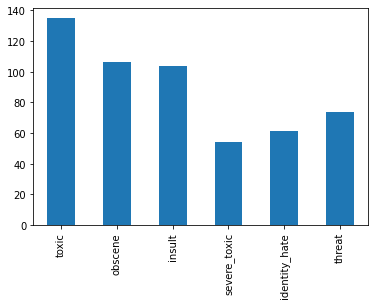

In [ ]:
# counts for fancy sampling method
resampled_df[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

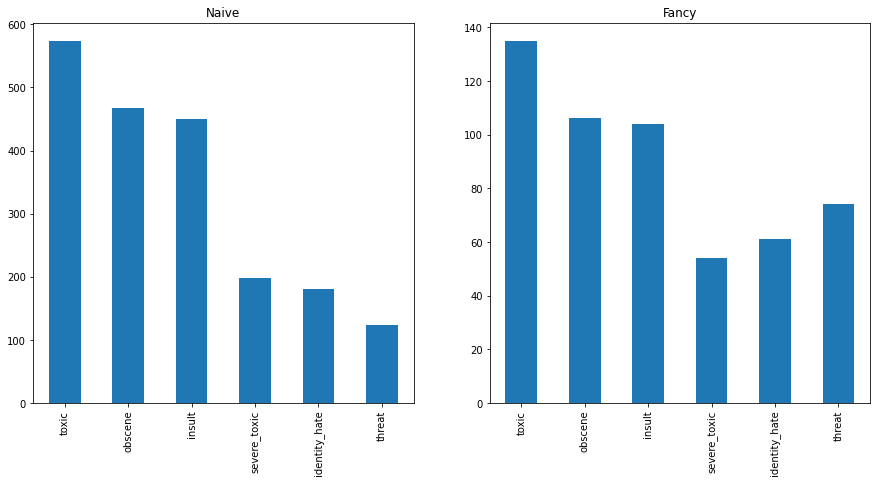

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
sampled_df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar(ax = axs[0], title = 'Naive')
resampled_df[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar(ax = axs[1], title = 'Fancy')

In [ ]:
# entropy for fancy sampling method. Higher than original and naive
categorical_entropy(resampled_df)

2.5112317814311114

In [ ]:
# 1000 iterations of each sampling method
naive_H, fancy_H = [], []
for i in tqdm(range(1000)):
    sampled_df = naive_sample(df, toxic_labels, 100)
    H = categorical_entropy(sampled_df, labels = toxic_labels) 
    naive_H.append(H)

for i in tqdm(range(1000)):
    sampled_df = fancy_sample(df, toxic_labels, 100, cooc_norm)
    H = categorical_entropy(sampled_df, labels = toxic_labels) 
    fancy_H.append(H)
    

100%|██████████| 1000/1000 [00:22<00:00, 44.27it/s]


In [ ]:
np.mean(naive_H)

2.3808926305485683

In [ ]:
np.mean(fancy_H)

2.516067036969578

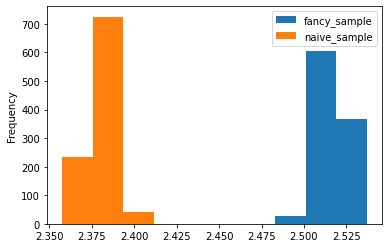

In [ ]:
# histogram of entropy values for each method. Fancy is clearly greater
hist_df = pd.DataFrame(data = {'fancy_sample' : fancy_H, 'naive_sample' : naive_H})
hist_df.plot.hist()